# Prereqs

In [1]:
!git clone https://github.com/stvschmdt/ne_ds5230.git

fatal: destination path 'ne_ds5230' already exists and is not an empty directory.


In [2]:
%cd ne_ds5230/prep_material

/content/ne_ds5230/prep_material


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
import seaborn as sns

from scipy.stats import zscore
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [4]:
raw_df = pd.read_csv('CC GENERAL.csv')
raw_df = raw_df.drop('CUST_ID', axis = 1)
raw_df.fillna(method ='ffill', inplace = True)
raw_df.head(2)

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.4,0.0,95.4,0.000000,0.166667,0.0,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.0,0.0,0.0,6442.945483,0.000000,0.0,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12


## Column Meanings
CUST_ID : Identification of Credit Card holder (Categorical) \
BALANCE : Balance amount left in their account to make purchases \
BALANCE_FREQUENCY : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated) \
PURCHASES : Amount of purchases made from account \
ONEOFF_PURCHASES : Maximum purchase amount done in one-go \
INSTALLMENTS_PURCHASES : Amount of purchase done in installment \
CASH_ADVANCE : Cash in advance given by the user \
PURCHASES_FREQUENCY : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased) \
ONEOFFPURCHASESFREQUENCY : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased) \
PURCHASESINSTALLMENTSFREQUENCY : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done) \
CASHADVANCEFREQUENCY : How frequently the cash in advance being paid \
CASHADVANCETRX : Number of Transactions made with "Cash in Advanced" \
PURCHASES_TRX : Numbe of purchase transactions made \
CREDIT_LIMIT : Limit of Credit Card for user \
PAYMENTS : Amount of Payment done by user \
MINIMUM_PAYMENTS : Minimum amount of payments made by user \
PRCFULLPAYMENT : Percent of full payment paid by user \
TENURE : Tenure of credit card service for user

# Exploratory Data Analysis

We want to:
* Divide data into discrete clusters
* Be able to visualize our clusters (2 dimensions)
* Answer interesting questions

To find trends between pairs of variables, we can plot a **correlation matrix**.

In [5]:
correlations = raw_df.corr('spearman')

<Axes: >

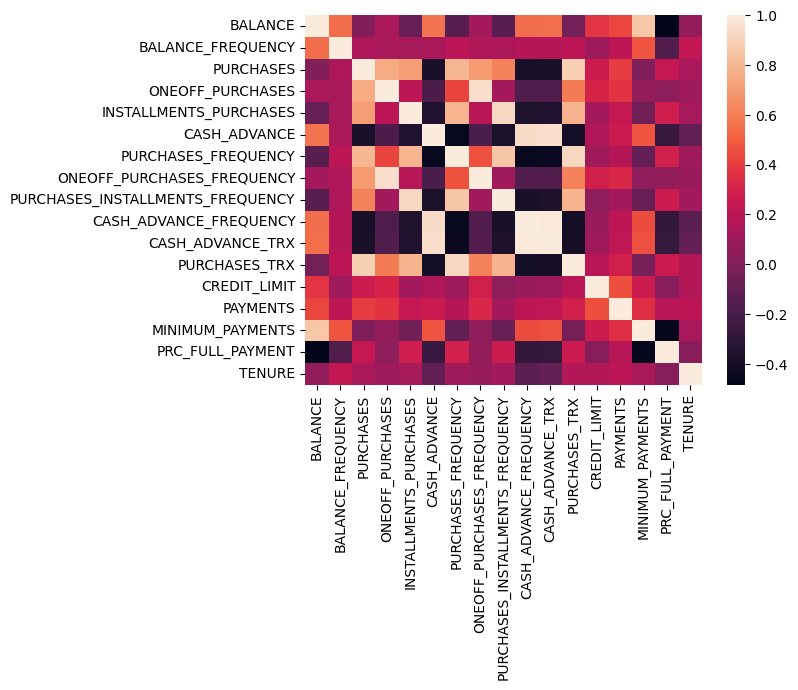

In [6]:
## TODO
## What is some simple EDA on this dataset that would make sense to determine which 2 features might be good for clustering

# Covariance matrix
sns.heatmap(correlations)

Many of these strong correlations are self-explanatory, such as CASH_ADVANCE_FREQUENCY and CASH_ADVANCE TRX.

What about BALANCE and MINIMUM_PAYMENTS? Are there any visible clusters here?

<Axes: xlabel='BALANCE', ylabel='MINIMUM_PAYMENTS'>

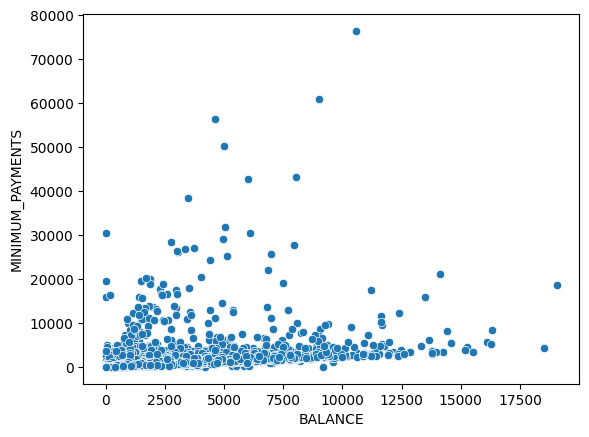

In [7]:
## TODO
## Plots, corr, cov...heuristics - this does not need to be robust, just some 'an' idea
sns.scatterplot(raw_df, x="BALANCE", y="MINIMUM_PAYMENTS")

How about CREDIT_LIMIT and BALANCE?

<Axes: xlabel='CREDIT_LIMIT', ylabel='BALANCE'>

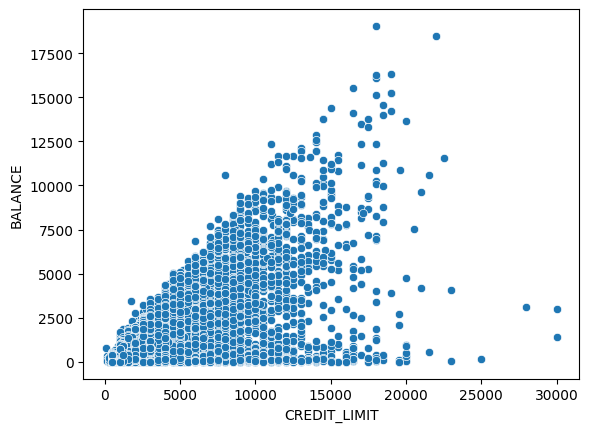

In [8]:
sns.scatterplot(raw_df, x="CREDIT_LIMIT", y="BALANCE")

One interesting observation from this chart is we see several distinct scenarios here:

* Person has low credit limit and low balance (less debt and low credit score)
* Person has large balance and large(ish) credit limit (more debt and high credit score)
* Person has low balance and high credit limit (less debt and high credit score)

What we don't see in this data is a high balance with a low credit limit. Why is this?

### Distributions

Let's try clustering the data according to credit limit and balance. First, let's take a look at the distribution of the data.

<Axes: xlabel='CREDIT_LIMIT', ylabel='Count'>

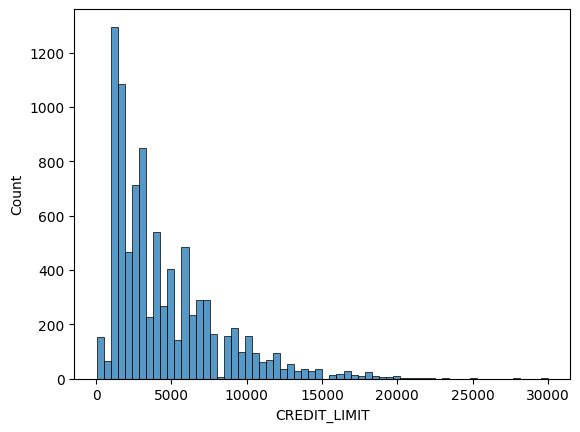

In [9]:
sns.histplot(raw_df, x="CREDIT_LIMIT")

<Axes: xlabel='BALANCE', ylabel='Count'>

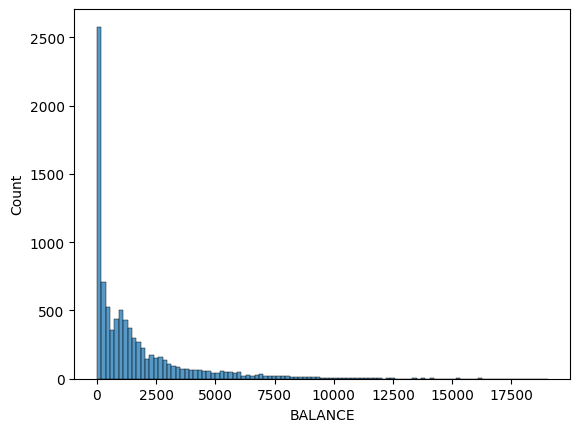

In [10]:
sns.histplot(raw_df, x="BALANCE")

Both of these distributions are very skewed, with counts highest at or slightly above 0.
* While a balance of 2500 is much less common than a balance of 0, a balance of 7500 is not much less common than a balance of 5000
* Same with credit limit - notice the difference in the count at 1000 and 5000, compared to 15000 and 20000.

How do we take this discrepancy into account?
One way to normalize: use the **z-scores**

In [11]:
## TODO
## given these two features, should one scale/normalize?
## what does that look like - regular vs scaled vs normalized
credit_limit_zscores = zscore(raw_df["CREDIT_LIMIT"])
balance_zscores = zscore(raw_df["BALANCE"])

Now let's see how our data looks!

<Axes: xlabel='CREDIT_LIMIT', ylabel='BALANCE'>

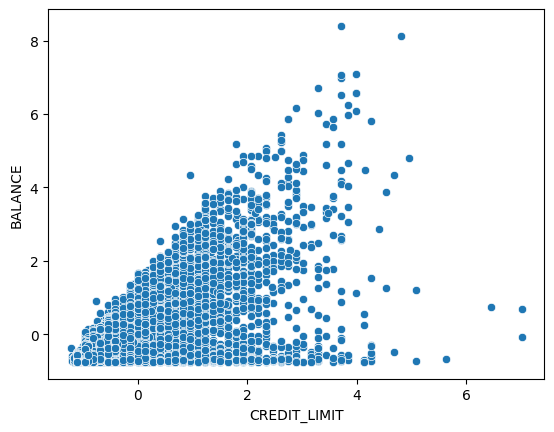

In [12]:
sns.scatterplot(x=credit_limit_zscores, y=balance_zscores)

Very similar trends to before, but we notice that datapoints tend to have a higher z-score for balance than for credit limit.

Another thing we can try: since our data is skewed right, we can try taking the **cube root** of our data.

In [13]:
scaler = StandardScaler().fit(raw_df[['CREDIT_LIMIT', 'BALANCE']])
data_scaled = scaler.transform(raw_df[['CREDIT_LIMIT', 'BALANCE']])
credit_limit_scaled = data_scaled[:, 0]
balance_scaled = data_scaled[:, 1]

<Axes: >

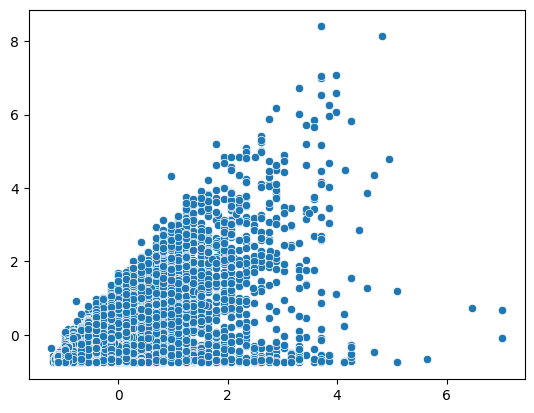

In [14]:
sns.scatterplot(x=credit_limit_scaled, y=balance_scaled)

Let's see if we can form clusters from this data.

# Hierarchical Agglomerative Clustering



## Hierarchical Clustering

<b>Hierarchical clustering </b> (also called hierarchical cluster analysis or HCA) is a method of cluster analysis which seeks to build a hierarchy of clusters. Strategies for hierarchical clustering generally fall into two types:

- <b>Agglomerative </b>: This is a "bottom-up" approach: each observation starts in its own cluster, and pairs of clusters are merged as one moves up the hierarchy.
- <b>Divisive </b>: This is a "top-down" approach: all observations start in one cluster, and splits are performed recursively as one moves down the hierarchy.

In general, the merges and splits are determined in a greedy manner. The results of hierarchical clustering are usually presented in a dendrogram.

## Agglomerative Clustering

Initially each data point is considered as an individual cluster. At each iteration, the similar clusters merge with other clusters until 1/ K clusters are formed.

The main advantage is that we don’t need to specify the number of clusters, this comes with a price: performance $O(n^3)$. In sklearn’s implementation, we can specify the number of clusters to assist the algorithm’s performance.

### Algorithm
- Compute the proximity matrix
- Let each data point be a cluster
- Repeat: Merge two closest clusters and update the proximity matrix until 1/ K cluster remains

Ex. - We have six data points {A,B,C,D,E,F}.

- In the initial step, we consider all the six data points as individual clusters as shown in the image below.

![Figure 1](https://github.com/stvschmdt/ne_ds5230/blob/main/prep_material/agglomerative_clustering_fig1.png?raw=1)

- The first step is to determine which elements to merge in a cluster. Usually, we want to take the two closest elements, according to the chosen distance.We construct a distance matrix at this stage, where the number in the i-th row j-th column is the distance between the i-th and j-th elements. Then, as clustering progresses, rows and columns are merged as the clusters are merged and the distances updated.

#### Computation of proximity/distance matrix

The choice of an appropriate metric will influence the shape of the clusters, as some elements may be close to one another according to one distance and farther away according to another. For example, in a 2-dimensional space, the distance between the point (1,0) and the origin (0,0) is always 1 according to the usual norms, but the distance between the point (1,1) and the origin (0,0) can be 2 under Manhattan distance, $\sqrt2$ under Euclidean distance, or 1 under maximum distance.

Some commonly used metrics for hierarchical clustering are:

![Table 1](https://github.com/stvschmdt/ne_ds5230/blob/main/prep_material/agglomerative_clustering_tab1.png?raw=1)

For text or other non-numeric data, metrics such as the Hamming distance or Levenshtein distance are often used.

- Similar clusters are merged together and formed as a single cluster. Let’s consider B,C, and D,E are similar clusters that are merged in step two. Now, we’re left with four clusters which are A, BC, DE, F. To calculate the proximity between two clusters, we need to define the distance between them. Usually the distance is one of the following:
     - The maximum distance between elements of each cluster (also called  <b> complete-linkage clustering </b>)
     - The minimum distance between elements of each cluster (also called <b> single-linkage clustering </b>)
     - The mean distance between elements of each cluster (also called <b> average linkage clustering </b>)
     - The sum of all intra-cluster variance.
- Again calculate the proximity of new clusters and merge the similar clusters to form new clusters A, BC, DEF.
- Calculate the proximity of the new clusters. The clusters DEF and BC are similar and merged together to form a new cluster. We’re now left with two clusters A, BCDEF.
- Finally, all the clusters are merged together and form a single cluster.



The Hierarchical clustering Technique can be visualized using a Dendrogram.
A Dendrogram is a tree-like diagram that records the sequences of merges or splits.

![Figure 2](https://github.com/stvschmdt/ne_ds5230/blob/main/prep_material/agglomerative_clustering_fig2.png?raw=1)

### Example


First, we'll try running hierarchical clustering on the raw data with different k values

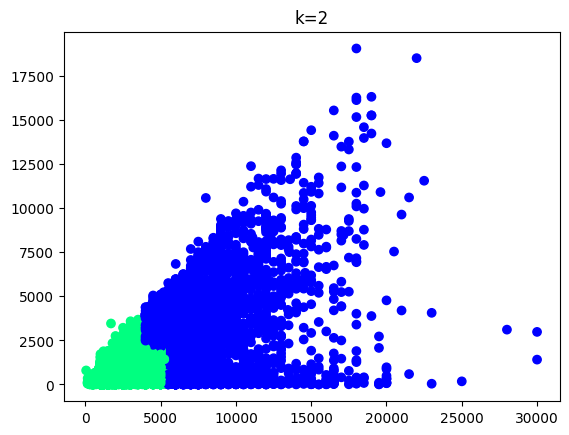

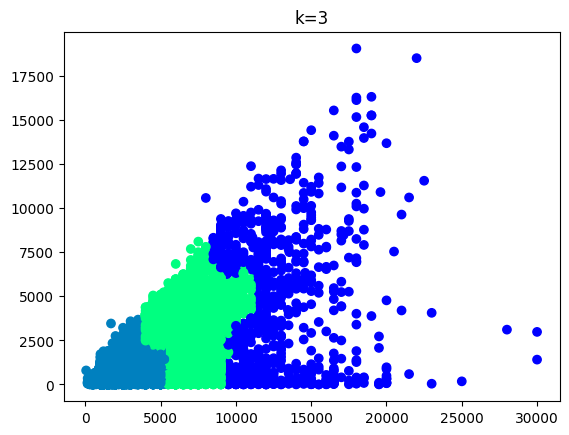

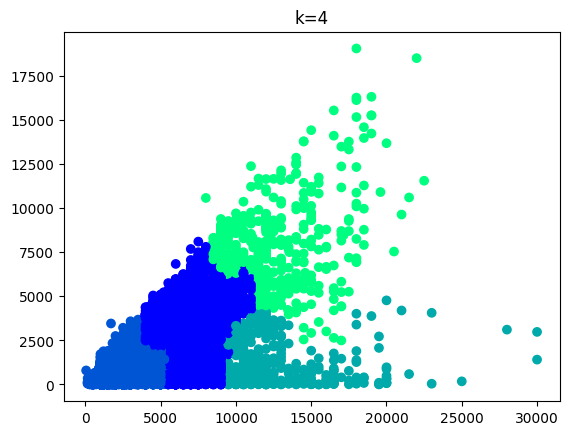

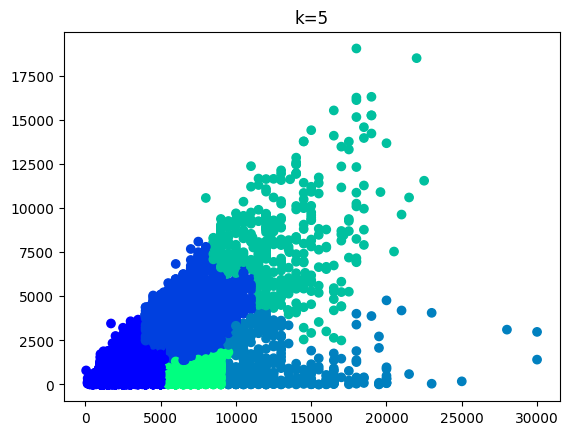

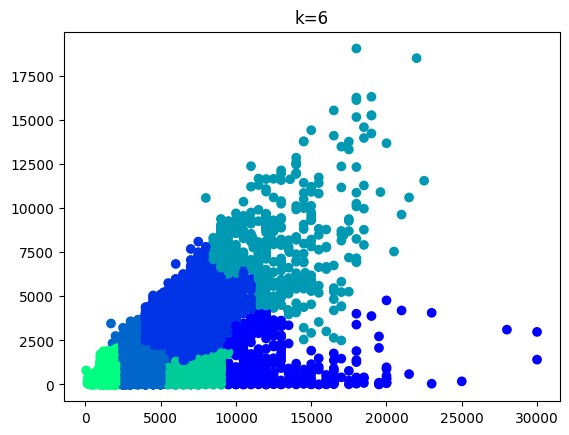

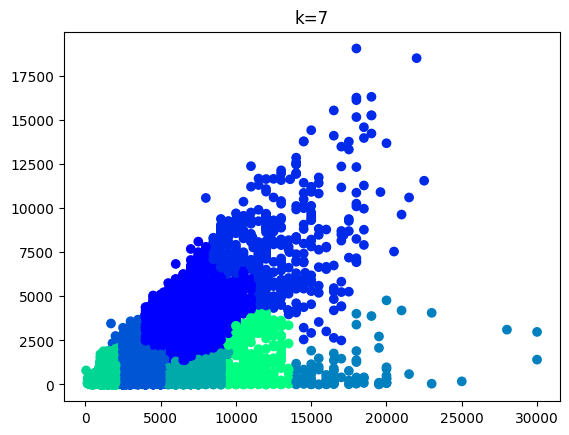

<Figure size 640x480 with 0 Axes>

In [15]:
for k in range(2, 8):
    plt.scatter(raw_df['CREDIT_LIMIT'], raw_df['BALANCE'],
           c = AgglomerativeClustering(n_clusters = k).fit_predict(raw_df[["CREDIT_LIMIT", "BALANCE"]]), cmap =plt.cm.winter)
    plt.title(f"k={k}")
    plt.show()
    plt.clf()

In [16]:
for k in range(2, 8):
    print(f"k={k}")
    clusters = AgglomerativeClustering(n_clusters = k).fit_predict(raw_df[["CREDIT_LIMIT", "BALANCE"]])
    unique, counts = np.unique(clusters, return_counts=True)
    for item in np.asarray((unique, counts)).T:
        print(f"Cluster {item[0]} count: {item[1]}")
    print("==========")

k=2
Cluster 0 count: 3228
Cluster 1 count: 5722
k=3
Cluster 0 count: 884
Cluster 1 count: 5722
Cluster 2 count: 2344
k=4
Cluster 0 count: 2344
Cluster 1 count: 5722
Cluster 2 count: 485
Cluster 3 count: 399
k=5
Cluster 0 count: 5722
Cluster 1 count: 1426
Cluster 2 count: 485
Cluster 3 count: 399
Cluster 4 count: 918
k=6
Cluster 0 count: 485
Cluster 1 count: 1426
Cluster 2 count: 2683
Cluster 3 count: 399
Cluster 4 count: 918
Cluster 5 count: 3039
k=7
Cluster 0 count: 1426
Cluster 1 count: 399
Cluster 2 count: 2683
Cluster 3 count: 113
Cluster 4 count: 918
Cluster 5 count: 3039
Cluster 6 count: 372


Now let's try clustering our normalized data!

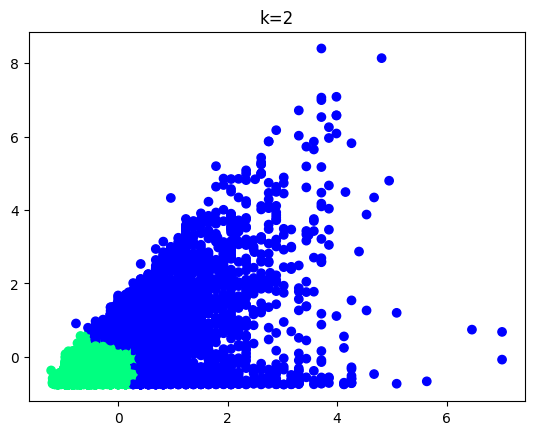

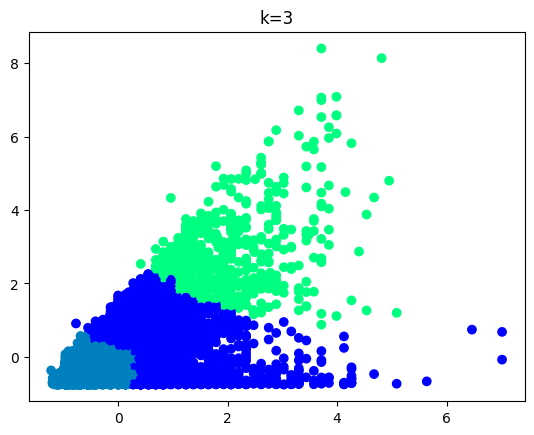

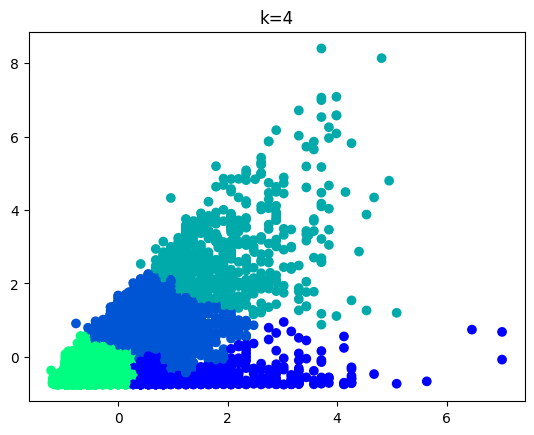

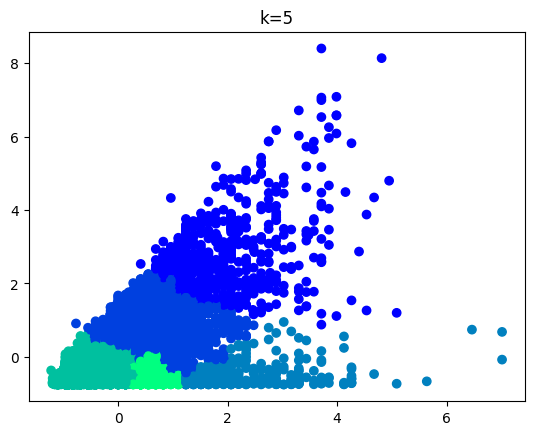

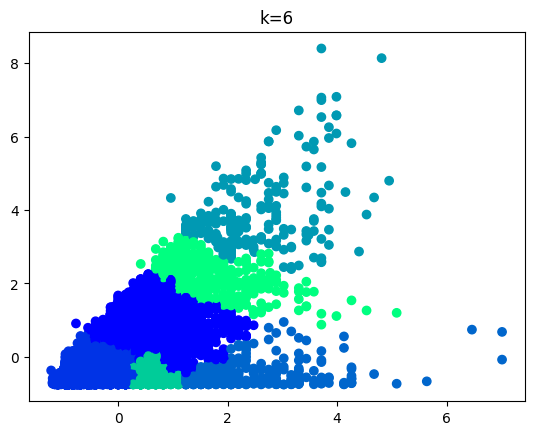

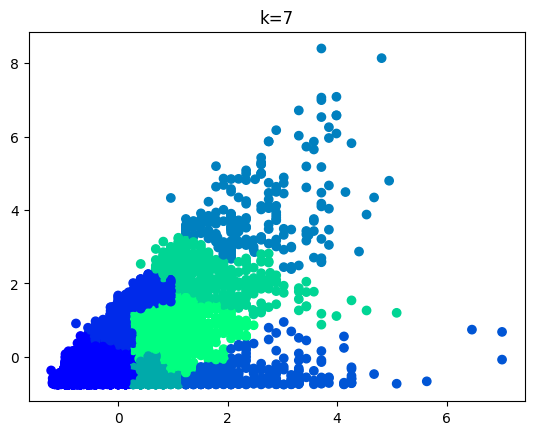

<Figure size 640x480 with 0 Axes>

In [17]:
for k in range(2, 8):
    # Visualizing the clustering

    plt.scatter(credit_limit_scaled, balance_scaled,
            c = AgglomerativeClustering(n_clusters = k).fit_predict(data_scaled), cmap =plt.cm.winter)
    plt.title(f"k={k}")
    plt.show()
    plt.clf()

In [18]:
for k in range(2, 8):
    print(f"k={k}")
    clusters = AgglomerativeClustering(n_clusters = k).fit_predict(data_scaled)
    unique, counts = np.unique(clusters, return_counts=True)
    for item in np.asarray((unique, counts)).T:
        print(f"Cluster {item[0]} count: {item[1]}")
    print("==========")

k=2
Cluster 0 count: 3427
Cluster 1 count: 5523
k=3
Cluster 0 count: 2874
Cluster 1 count: 5523
Cluster 2 count: 553
k=4
Cluster 0 count: 1189
Cluster 1 count: 1685
Cluster 2 count: 553
Cluster 3 count: 5523
k=5
Cluster 0 count: 553
Cluster 1 count: 1685
Cluster 2 count: 401
Cluster 3 count: 5523
Cluster 4 count: 788
k=6
Cluster 0 count: 1685
Cluster 1 count: 5523
Cluster 2 count: 401
Cluster 3 count: 213
Cluster 4 count: 788
Cluster 5 count: 340
k=7
Cluster 0 count: 5523
Cluster 1 count: 828
Cluster 2 count: 401
Cluster 3 count: 213
Cluster 4 count: 788
Cluster 5 count: 340
Cluster 6 count: 857


Which clusters are more ideal? One way to decide this is to use the **silhouette score**. Let's calculate it at each value of k for the raw data.

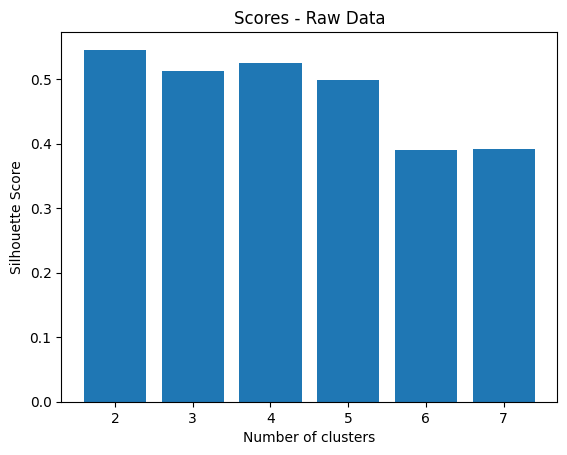

In [19]:
silhouette_scores = []

for k in range(2, 8):
    silhouette_scores.append(
        silhouette_score(raw_df[["CREDIT_LIMIT", "BALANCE"]], AgglomerativeClustering(n_clusters = k).fit_predict(raw_df[["CREDIT_LIMIT", "BALANCE"]])))

# Plotting a bar graph to compare the results
k = [2, 3, 4, 5, 6,7]
plt.bar(k, silhouette_scores)
plt.xlabel('Number of clusters', fontsize = 10)
plt.ylabel('Silhouette Score', fontsize = 10)
plt.title("Scores - Raw Data")
plt.show()

Now let's get the silhouette scores for the normalized data!

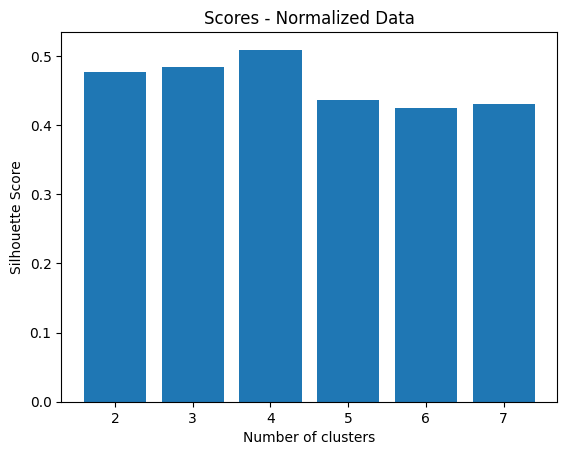

In [20]:
silhouette_scores = []

for k in range(2, 8):
    silhouette_scores.append(
        silhouette_score(data_scaled, AgglomerativeClustering(n_clusters = k).fit_predict(data_scaled)))

# Plotting a bar graph to compare the results
k = [2, 3, 4, 5, 6,7]
plt.bar(k, silhouette_scores)
plt.xlabel('Number of clusters', fontsize = 10)
plt.ylabel('Silhouette Score', fontsize = 10)
plt.title("Scores - Normalized Data")
plt.show()

We see that with fewer clusters, the raw data performs better, but with more clusters, the scaled data achieves a higher silhouette score.

# K-Means Clustering

Agglomerative clustering isn't the only type of cluster analysis available to us! A popular method clustering is called **k-means** clustering, where given a specified number of clusters, we iterate through each data point and choose which cluster to assign the point to based on its nearest *centroid*.

**Centroid** - A centroid is a data point at the center of a cluster. In centroid-based clustering, clusters are represented by a centroid. It is an iterative algorithm in which the notion of similarity is derived by how close a data point is to the centroid of the cluster.

## How the algorithm works
The k-means algorithm starts with initial estimates for the K centroids. The algorithm then iterates between two steps:

1. **Data assignment step**: Each centroid defines one of the clusters. In this step, each data point is assigned to its nearest centroid, which is based on the squared Euclidean distance. So, if ci is the collection of centroids in set C, then each data point is assigned to a cluster based on minimum Euclidean distance.

2. **Centroid update step**: In this step, the centroids are recomputed and updated. This is done by taking the mean of all data points assigned to that centroid's cluster.

The algorithm then iterates between step 1 and step 2 until a stopping criteria is met. Stopping criteria means no data points change the clusters, the sum of the distances is minimized or some maximum number of iterations is reached. This algorithm is guaranteed to converge to a result. The result may be a local optimum meaning that assessing more than one run of the algorithm with randomized starting centroids may give a better outcome.


![Figure 3](https://github.com/stvschmdt/ne_ds5230/blob/main/prep_material/kmeans_fig1.png?raw=1)

Let's try running k-means on the raw data with different k values

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


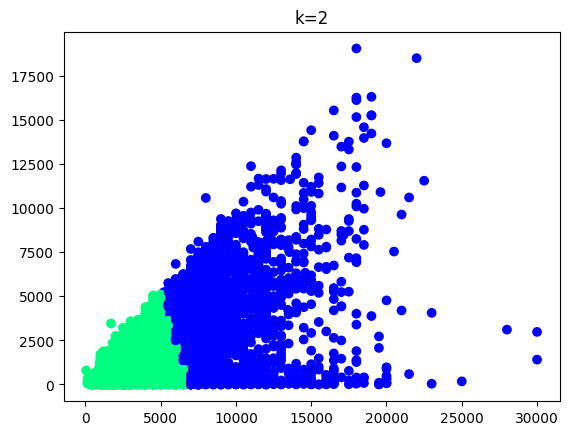

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


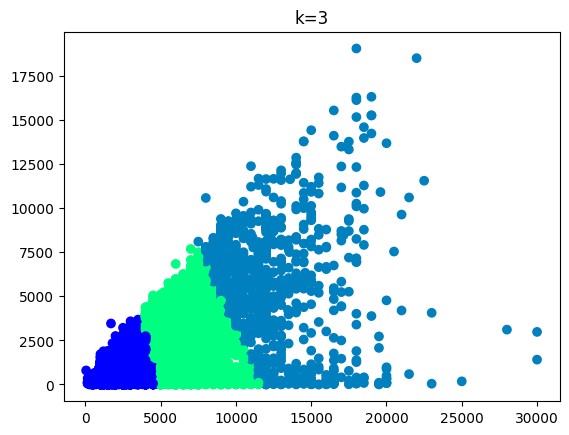

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


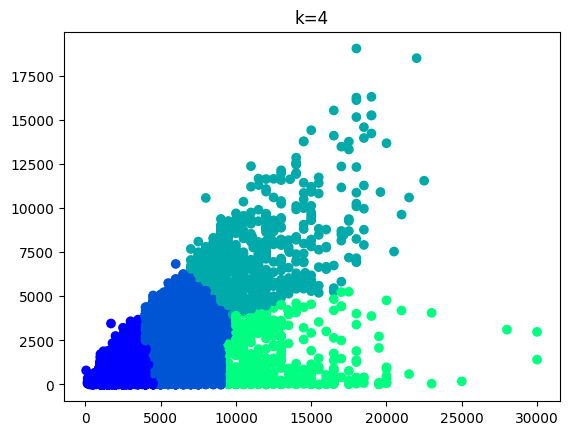

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


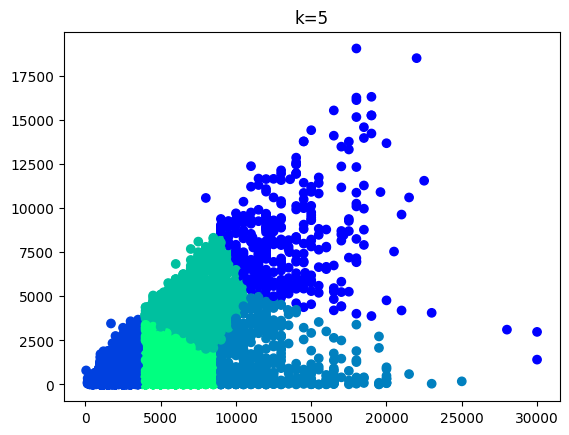

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


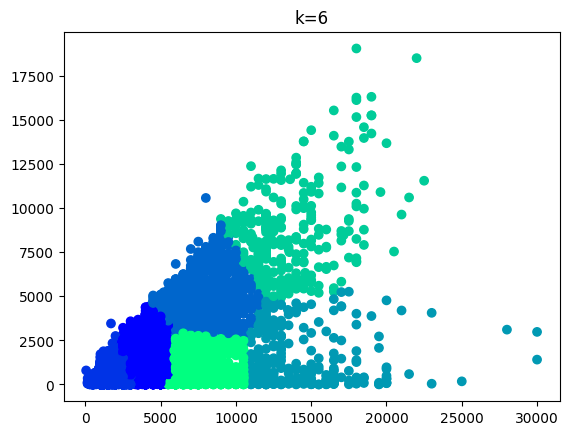

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


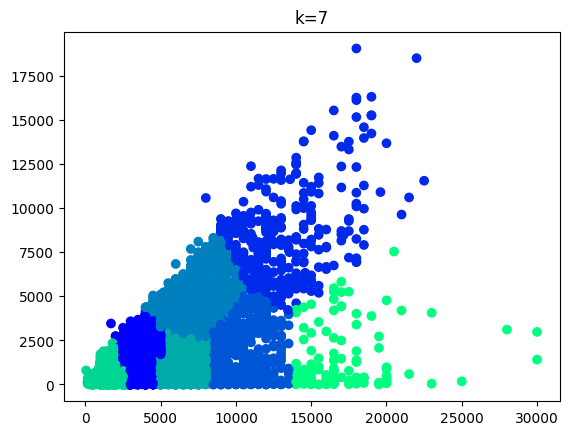

<Figure size 640x480 with 0 Axes>

In [28]:
for k in range(2, 8):
    plt.scatter(raw_df['CREDIT_LIMIT'], raw_df['BALANCE'],
           c = KMeans(n_clusters = k).fit_predict(raw_df[["CREDIT_LIMIT", "BALANCE"]]), cmap =plt.cm.winter)
    plt.title(f"k={k}")
    plt.show()
    plt.clf()

In [29]:
for k in range(2, 8):
    print(f"k={k}")
    clusters = KMeans(n_clusters = k).fit_predict(raw_df[["CREDIT_LIMIT", "BALANCE"]])
    unique, counts = np.unique(clusters, return_counts=True)
    for item in np.asarray((unique, counts)).T:
        print(f"Cluster {item[0]} count: {item[1]}")
    print("==========")

k=2


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0 count: 6584
Cluster 1 count: 2366
k=3


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0 count: 2676
Cluster 1 count: 825
Cluster 2 count: 5449
k=4


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0 count: 5369
Cluster 1 count: 519
Cluster 2 count: 2488
Cluster 3 count: 574
k=5


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0 count: 4847
Cluster 1 count: 1056
Cluster 2 count: 2097
Cluster 3 count: 347
Cluster 4 count: 603
k=6


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0 count: 938
Cluster 1 count: 3550
Cluster 2 count: 2464
Cluster 3 count: 298
Cluster 4 count: 1397
Cluster 5 count: 303
k=7


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0 count: 164
Cluster 1 count: 3535
Cluster 2 count: 1299
Cluster 3 count: 2310
Cluster 4 count: 811
Cluster 5 count: 260
Cluster 6 count: 571


Now let's try clustering our normalized data!

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


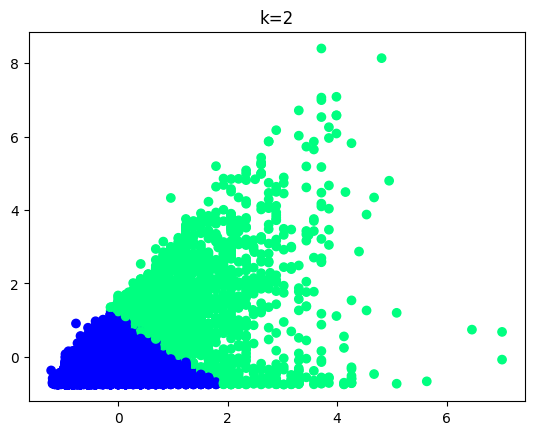

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


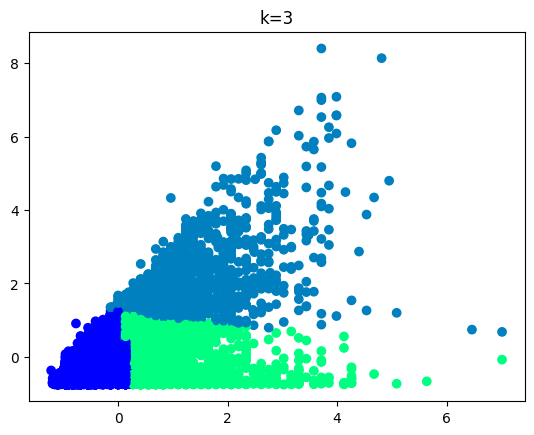

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


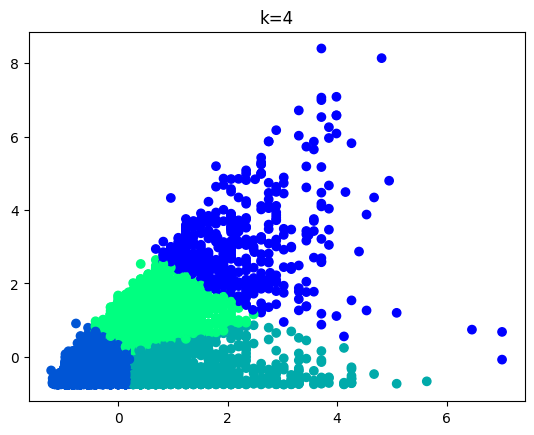

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


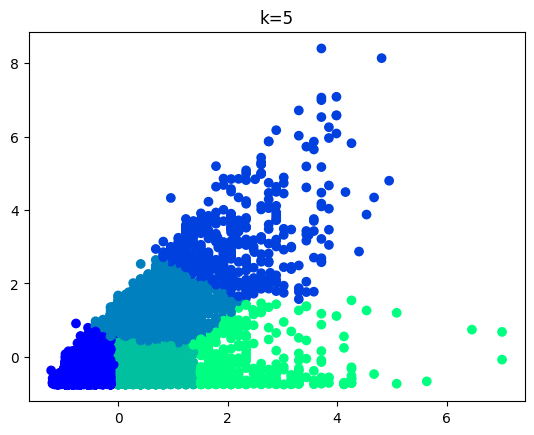

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


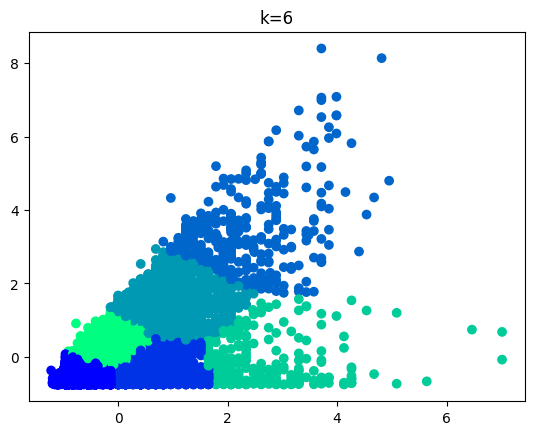

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


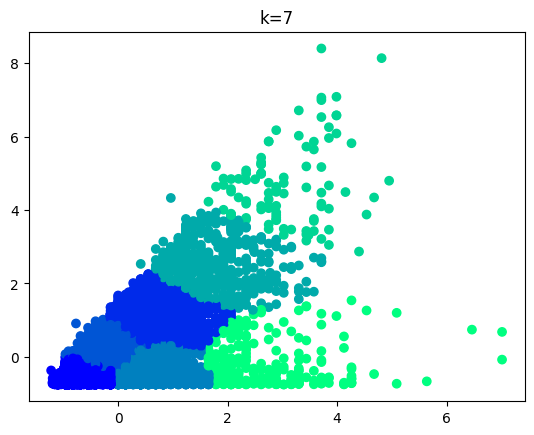

<Figure size 640x480 with 0 Axes>

In [30]:
for k in range(2, 8):
    # Visualizing the clustering

    plt.scatter(credit_limit_scaled, balance_scaled,
            c = KMeans(n_clusters = k).fit_predict(data_scaled), cmap =plt.cm.winter)
    plt.title(f"k={k}")
    plt.show()
    plt.clf()

In [31]:
for k in range(2, 8):
    print(f"k={k}")
    clusters = KMeans(n_clusters = k).fit_predict(data_scaled)
    unique, counts = np.unique(clusters, return_counts=True)
    for item in np.asarray((unique, counts)).T:
        print(f"Cluster {item[0]} count: {item[1]}")
    print("==========")

k=2


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0 count: 7211
Cluster 1 count: 1739
k=3


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0 count: 5860
Cluster 1 count: 2097
Cluster 2 count: 993
k=4


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0 count: 1292
Cluster 1 count: 5691
Cluster 2 count: 447
Cluster 3 count: 1520
k=5


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0 count: 5253
Cluster 1 count: 406
Cluster 2 count: 1650
Cluster 3 count: 1218
Cluster 4 count: 423
k=6


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0 count: 293
Cluster 1 count: 4268
Cluster 2 count: 986
Cluster 3 count: 336
Cluster 4 count: 1598
Cluster 5 count: 1469
k=7


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0 count: 3876
Cluster 1 count: 333
Cluster 2 count: 1520
Cluster 3 count: 1018
Cluster 4 count: 103
Cluster 5 count: 450
Cluster 6 count: 1650


To figure out which data is best for clustering at different k values, let's again plot the **silhouette score**.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

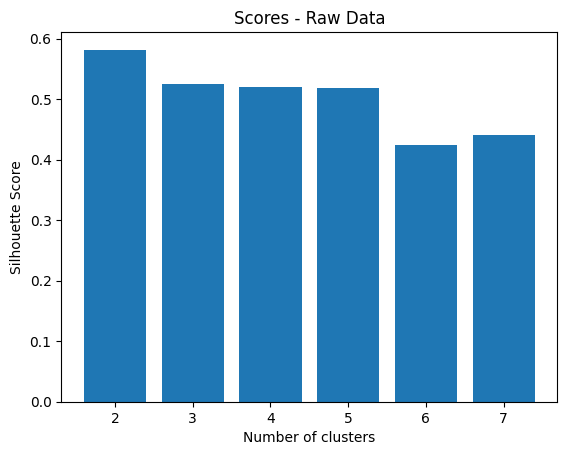

In [32]:
silhouette_scores = []

for k in range(2, 8):
    silhouette_scores.append(
        silhouette_score(raw_df[["CREDIT_LIMIT", "BALANCE"]], KMeans(n_clusters = k).fit_predict(raw_df[["CREDIT_LIMIT", "BALANCE"]])))

# Plotting a bar graph to compare the results
k = [2, 3, 4, 5, 6,7]
plt.bar(k, silhouette_scores)
plt.xlabel('Number of clusters', fontsize = 10)
plt.ylabel('Silhouette Score', fontsize = 10)
plt.title("Scores - Raw Data")
plt.show()

Now let's get the silhouette scores for the normalized data!

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

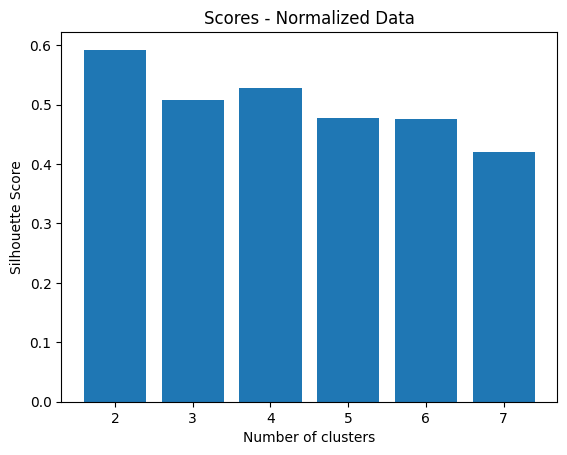

In [33]:
silhouette_scores = []

for k in range(2, 8):
    silhouette_scores.append(
        silhouette_score(data_scaled, KMeans(n_clusters = k).fit_predict(data_scaled)))

# Plotting a bar graph to compare the results
k = [2, 3, 4, 5, 6,7]
plt.bar(k, silhouette_scores)
plt.xlabel('Number of clusters', fontsize = 10)
plt.ylabel('Silhouette Score', fontsize = 10)
plt.title("Scores - Normalized Data")
plt.show()

In this case, the normalized data works best at k=2, k=4, and k=6

# When to use different clustering algorithms


## Hierarchical Agglomerative Clustering vs. K-Means

As we saw, hierarchical agglomerative clustering yields a dendrogram of nested clusters. This can be very useful when we don't know how many clusters we need, or when we want to apply a hierarchical structure to our data.

But hierarchical agglomerative clustering is very computationally expensive! Compare the time it took to draw the dendrogram to the time it took to run k-means given a predefined k value. Because of this, k-means is often preferred for large datasets. K-means works particularly well when your data has circular or spherical clusters.

## Can we use K-means in every scenario?

K-means works well when your data contains circular clusters, but this is not always the case!

![Figure 4](https://github.com/stvschmdt/ne_ds5230/blob/main/prep_material/kmeans_fig2.png?raw=1)

**Gaussian Mixture Models** (GMMs) take into account the *variance* as well as the centroid of a cluster, and can create oval-shaped clusters as well as circular ones.

![Figure 5](https://github.com/stvschmdt/ne_ds5230/blob/main/prep_material/kmeans_fig3.png?raw=1)

As a result, GMMs can produce clusters that better match the data distribution.

![Figure 6](https://github.com/stvschmdt/ne_ds5230/blob/main/prep_material/kmeans_fig4.png?raw=1)

Image credits: https://www.blog.dailydoseofds.com/p/gaussian-mixture-models-the-flexible

References:
* https://www.kaggle.com/code/prashant111/k-means-clustering-with-python#3.-K-Means-Clustering-intuition-
* https://www.kaggle.com/code/vipulgandhi/hierarchical-clustering-explanation